# Demonstration of digital modulation principles

This demo is supposed to shed some light on the principles of [digital modulation techniquies](https://en.wikipedia.org/wiki/Modulation#Digital_modulation_methods). 

This demo is written by [Markus Nölle](https://www.htw-berlin.de/hochschule/personen/person/?eid=9586) for a basic course on [communications engineering](https://en.wikipedia.org/wiki/Telecommunications_engineering) hold at the [university of applied siences, Berlin](https://www.htw-berlin.de/).

## Import libraries and set defaults

In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ipywidgets as widgets

plt.style.use('noelle.mplstyle')

## General parameters

Basic parameters like sample rate, time axis and frequency axis are defined.

In [2]:
sr = 120000
symb_rate = 200 # symbol rate (has to be an even integer divider of sr)

n_symb_show = 10
fc = 600 # carrier frequency
t = np.linspace(0, 1-1/sr, int(sr))
f = np.fft.fftshift(np.fft.fftfreq(np.size(t), 1/sr))
n = np.size(t) # length of signal
n_symb = symb_rate # always 1 s simulation time
sps = sr/symb_rate # samples per symbol

## Signal generation and mapping

In [3]:
def signal_generation_mapping(levels, bipolar, quadrature):
    
    #levels = 2 # amplitude levels of I and Q
    #bipolar = True # unipolar or bipolar
    #quadrature = True # use quadrature modulation?
    
    global x_bits_i, x_bits_q
    
    np.random.seed(0)    
    x_bits_i = np.random.randint(0, levels, n_symb)
    x_bits_q = np.zeros_like(x_bits_i)

    if bipolar:
        x_bits_i = (x_bits_i-(levels - 1)/2)*2

    if quadrature:
        x_bits_q = np.random.randint(0, levels, n_symb)
        if bipolar:
            x_bits_q = (x_bits_q-(levels - 1)/2)*2

    n_row = 1
    n_col = 3
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)

    ax = fig.add_subplot(n_row, n_col, 1)
    plt.stem(x_bits_i[0:n_symb_show], markerfmt='C0o', linefmt='C0', use_line_collection=True)
    ax.set(xlabel="time / samples", ylabel="inphase amplitude / a.u.", ylim=(-np.max(x_bits_i)*1.1, np.max(x_bits_i)*1.1))

    ax = fig.add_subplot(n_row, n_col, 2)
    plt.stem(x_bits_q[0:n_symb_show], markerfmt='C1o', linefmt='C1', use_line_collection=True)
    ax.set(xlabel="time / samples", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_bits_i)*1.1, np.max(x_bits_i)*1.1))

    ax = fig.add_subplot(n_row, n_col, 3)
    plt.plot(x_bits_i, x_bits_q, ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="inphase amplitude / a.u.", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_bits_i)*1.1, np.max(x_bits_i)*1.1), xlim=(-np.max(x_bits_i)*1.1, np.max(x_bits_i)*1.1));
    ax.set_aspect('equal','box')

    plt.tight_layout()
    
# generate sliders (widgets)
w_levels = widgets.IntSlider(min=2, max=16, step=2, value=2, continuous_update=False, description='no. levels:')
w_bipolar = widgets.Checkbox(value=False, description='Bipolar signal?', disabled=False)
w_quadrature = widgets.Checkbox(value=False, description='Quadrature signal?', disabled=False)

ui = widgets.HBox([w_levels, w_bipolar, w_quadrature])


# call function (generate output)
out = widgets.interactive_output(signal_generation_mapping, {'levels':w_levels, 'bipolar':w_bipolar, 'quadrature':w_quadrature})
out.layout.height = '300px'

# display all
display(ui, out)

Output(layout=Layout(height='300px'))

## Pulseshaping

In [4]:
def pulseshaping(type, alpha):
    
    global x_i, x_q
    
    # generate filter inpule response
    if type == 'rect':
        # rect
        h = np.ones(int(sps))
    elif type == 'RC':
        # RC
        N = 20 * sps
        t_filter = np.arange(-np.ceil(N/2)+1, np.floor(N/2)+1)
        T = sps 
        with np.errstate(divide='ignore',invalid='ignore'):# avoid raising an divide by zero / NaN warning
            h = ((np.sin(np.pi*t_filter/T)) / (np.pi*t_filter/T)) * ((np.cos(alpha*np.pi*t_filter/T)) / (1-(2*alpha*t_filter/T)**2))
        h[t_filter==0] = 1
        if alpha != 0.0:
            h[np.abs(t_filter) == (T/(2*alpha))] = np.sin(np.pi/2/alpha) / (np.pi/2/alpha) * np.pi / 4
    elif type == 'RRC':
        # RRC
        N = 20 * sps
        t_filter = np.arange(-np.ceil(N/2)+1, np.floor(N/2)+1)
        T = sps
        with np.errstate(divide='ignore',invalid='ignore'):# avoid raising an divide by zero / NaN warning
            h = (np.sin(np.pi * t_filter / T * (1-alpha)) + 4 * alpha * t_filter / T * np.cos(np.pi * t_filter / T * (1 + alpha))) / (np.pi * t_filter / T * (1 - (4 * alpha * t_filter / T)**2))
        h[t_filter==0] = (1 - alpha + 4 * alpha / np.pi)
        if alpha != 0.0:
            h[np.abs(t_filter)==T/4/alpha] = alpha / np.sqrt(2) * ((1 + 2 / np.pi) * np.sin(np.pi / 4 / alpha) + (1 - 2 / np.pi) * np.cos(np.pi / 4 / alpha))


    x_i = signal.upfirdn(h, x_bits_i, sps)
    x_q = signal.upfirdn(h, x_bits_q, sps)

    if x_i.size != x_bits_i.size*sps:
        cut = x_i.size-(np.max((x_bits_i.size*sps,h.size)))
        x_i = x_i[np.int(np.floor(cut/2)):-np.int(np.ceil(cut/2))]
        x_q = x_q[np.int(np.floor(cut/2)):-np.int(np.ceil(cut/2))]

    # plotting
    n_row = 2
    n_col = 3
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)

    ax = fig.add_subplot(n_row, n_col, 1)
    plt.plot(t[0:np.int(n_symb_show*sps):], x_i[0:np.int(n_symb_show*sps):] ,'C0')
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_i[0:n_symb_show:], ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="time / s", ylabel="inphase amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 4)
    plt.plot(t[0:np.int(2*sps):], np.reshape(x_i,(np.int(2*sps),-1),order='F') ,'C0')
    ax.set(xlabel="time / s", ylabel="inphase amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 2)
    plt.plot(t[0:np.int(n_symb_show*sps):], x_q[0:np.int(n_symb_show*sps):] ,'C1')
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_q[0:n_symb_show:], ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="time / s", ylabel="quadrature amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 5)
    plt.plot(t[0:np.int(2*sps):], np.reshape(x_q,(np.int(2*sps),-1),order='F') ,'C1')
    ax.set(xlabel="time / s", ylabel="quadrature amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 3)
    plt.plot(x_i, x_q ,'C9')
    plt.plot(x_bits_i, x_bits_q, ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="inphase amplitude / a.u.", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_i)*1.1, np.max(x_i)*1.1), xlim=(-np.max(x_i)*1.1, np.max(x_i)*1.1));
    ax.set_aspect('equal','box')

    plt.tight_layout()
    
# generate sliders (widgets)
w_alpha = widgets.FloatSlider(min=0.0, max=1.0, step=0.05, value=0.5, continuous_update=False, description='rolloff:')
w_type = widgets.RadioButtons(options=['RC', 'RRC', 'rect'], value='RC', description='pulseshape:')

ui = widgets.HBox([w_type, w_alpha])


# call function (generate output)
out = widgets.interactive_output(pulseshaping, {'type':w_type, 'alpha':w_alpha})
out.layout.height = '600px'

# display all
display(ui, out)
    

Output(layout=Layout(height='600px'))

## IQ-Modulation

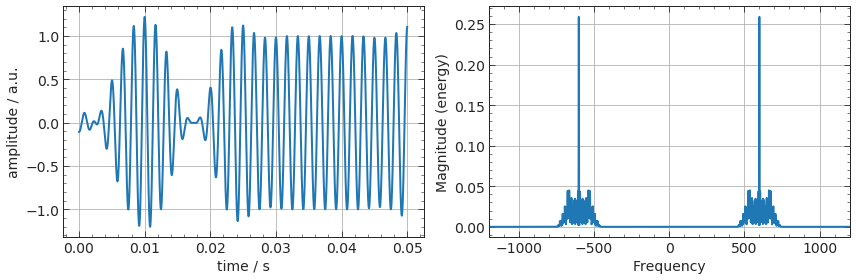

In [5]:
def iq_modulation():
    
    global x_i, x_q, x_mod, fc
        
    c_i = np.cos(2*np.pi*fc*t)
    c_q = -np.sin(2*np.pi*fc*t)

    x_mod = x_i*c_i + x_q*c_q

    # plotting
    n_row = 1
    n_col = 2
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)

    ax = fig.add_subplot(n_row, n_col, 1)
    plt.plot(t[0:np.int(n_symb_show*sps):], x_mod[0:np.int(n_symb_show*sps):] ,'C0')
    ax.set(xlabel="time / s", ylabel="amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 2)
    ax.magnitude_spectrum(x_mod ,sides="twosided", Fs=sr, scale="linear", color='C0')
    ax.set_xlim((-2*fc,2*fc))

    plt.tight_layout()
    
iq_modulation()
    
# # generate sliders (widgets)
# w_fc = widgets.FloatSlider(min=100, max=1000, step=100, value=600, continuous_update=False, description='fc:')


# ui = widgets.HBox([w_fc])


# # call function (generate output)
# out = widgets.interactive_output(iq_modulation, {'fc':w_fc})
# out.layout.height = '300px'

# # display all
# display(ui, out)



## IQ-Demodulation

In [6]:
def iq_demodulation(dphi, df):
    
#     dphi = 0*np.pi/8
#     df = 0*1

    global x_bits_i, x_bits_q, x_mod, fc

    # demod of I
    c = np.cos(2*np.pi*(fc+df)*t + dphi)
    x_i_demod = x_mod * c
    # demod of Q
    c = -np.sin(2*np.pi*(fc+df)*t + dphi)
    x_q_demod = x_mod * c

    # lowpass
    # sinc / rect in freq. domain with cutoff equal to fc
    tmp = np.linspace(-fc*np.pi,fc*np.pi, int(symb_rate*sps))
    h = np.sin(tmp)/tmp
    h /= 0.5*np.sum(h)
    
    
    # filter signal
    x_i_demod_filt = signal.convolve(x_i_demod, h, 'same')
    x_q_demod_filt = signal.convolve(x_q_demod, h, 'same')
    # cut filter effects
    x_i_demod_filt = x_i_demod_filt[int(20*sps):-int(20*sps)]
    x_q_demod_filt = x_q_demod_filt[int(20*sps):-int(20*sps)]
    # prepare sent symobls
    x_bits_i_tmp = x_bits_i[20:-20]
    x_bits_q_tmp = x_bits_q[20:-20]

    # sample
    start = int(sps/2)
    x_plot = x_i_demod_filt[start:-1:int(sps)] + 1j*x_q_demod_filt[start:-1:int(sps)]

    # normalize
    #xPlot = xPlot/max(abs(xPlot))*sqrt(2)

    # plotting
    n_row = 2
    n_col = 3
    fig_size = [i*j for i,j in zip(plt.rcParams['figure.figsize'], [n_col, n_row])]
    fig = plt.figure(figsize=fig_size)
        
    ax = fig.add_subplot(n_row, n_col, 1)
    plt.plot(t[0:np.int(n_symb_show*sps):], x_i_demod_filt[0:np.int(n_symb_show*sps):] ,'C0')
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_i_tmp[0:n_symb_show:], ls='',marker='o',markeredgecolor=(0.5, 0.5, 0.5), markerfacecolor=(0.8, 0.8, 0.8), ms=10, mew=3)
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], np.real(x_plot[0:n_symb_show:]), ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="time / s", ylabel="inphase amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 4)
    plt.plot(t[0:np.int(2*sps):], np.reshape(x_i_demod_filt,(np.int(2*sps),-1),order='F') ,'C0')
    ax.set(xlabel="time / s", ylabel="inphase amplitude / a.u.")

    ax = fig.add_subplot(n_row, n_col, 2)
    plt.plot(t[0:np.int(n_symb_show*sps):], x_q_demod_filt[0:np.int(n_symb_show*sps):] ,'C1')
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], x_bits_q_tmp[0:n_symb_show:], ls='',marker='o',markeredgecolor=(0.5, 0.5, 0.5), markerfacecolor=(0.8, 0.8, 0.8), ms=10, mew=3)
    plt.plot(t[np.int(sps/2)-1:np.int((n_symb_show+0.5)*sps-1):np.int(sps)], np.imag(x_plot[0:n_symb_show:]), ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="time / s", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_i_demod_filt)*1.1, np.max(x_i_demod_filt)*1.1))

    ax = fig.add_subplot(n_row, n_col, 5)
    plt.plot(t[0:np.int(2*sps):], np.reshape(x_q_demod_filt,(np.int(2*sps),-1),order='F') ,'C1')
    ax.set(xlabel="time / s", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_i_demod_filt)*1.1, np.max(x_i_demod_filt)*1.1))

    ax = fig.add_subplot(n_row, n_col, 3)
    plt.plot(x_i_demod_filt, x_q_demod_filt ,'C9')
    plt.plot(x_bits_i_tmp, x_bits_q_tmp, ls='',marker='o',markeredgecolor=(0.5, 0.5, 0.5), markerfacecolor=(0.8, 0.8, 0.8), ms=10, mew=3)
    plt.plot(np.real(x_plot), np.imag(x_plot), ls='',marker='o',markeredgecolor=(1.0, 0.0, 0.0), markerfacecolor=(1.0, 0.8, 0.3), ms=10, mew=3)
    ax.set(xlabel="inphase amplitude / a.u.", ylabel="quadrature amplitude / a.u.", ylim=(-np.max(x_i_demod_filt)*1.1, np.max(x_i_demod_filt)*1.1), xlim=(-np.max(x_i_demod_filt)*1.1, np.max(x_i_demod_filt)*1.1));
    ax.set_aspect('equal','box')

    plt.tight_layout()
    
# generate sliders (widgets)
w_dphi = widgets.FloatSlider(min=0.0, max=2*np.pi, step=0.1, value=0, continuous_update=False, description='$\Delta \phi$:')
w_df = widgets.FloatSlider(min=0.0, max=10, step=0.1, value=0, continuous_update=False, description='$\Delta f$:')

ui = widgets.HBox([w_dphi, w_df])


# call function (generate output)
out = widgets.interactive_output(iq_demodulation, {'dphi':w_dphi, 'df':w_df})
out.layout.height = '600px'

# display all
display(ui, out)


Output(layout=Layout(height='600px'))

In [7]:
sps

600.0